Imputing scRNA-seq data with MAGIC<br>
Paper: <a href="http://www.biorxiv.org/content/early/2017/02/25/111591">MAGIC: A diffusion-based imputation method reveals gene-gene interactions in single-cell RNA-sequencing data</a><br>
Code: https://github.com/pkathail/magic<br>


Single-cell RNA-seq data suffers from a large degree of noise in specific stemming from missing molecules, also termed 'dropout', leading to highly sparse data with around 90% zeros. This obscures the underlying biological signals and in specific it impedes analysis of gene-gene interactions, e.g. correlations.

Here we present MAGIC, a data imputation method that fills in the missing values and generaly denoises the data. MAGIC (Markov Affinity-based Graph Imputation of Cells) uses data diffusion on a k-nearest neighbor graph to exchange molecules between biologically similar cells. As a result, the diffusion process learns the underlying manifold of the data and reconstructs the data using it.

In this notebook we will setup MAGIC from scratch and run it on a scRNA-seq dataset of ~7000 single cells from a breast cancer cell line (HMLE) undergoing TGFb induced EMT (epithelial-to-mesenchymal transition).

MAGIC consists of the following steps:
1) Compute a distance matrix
2) Convert distances into affinities using a kernel
3) Markov normalize the kernel to get a diffusion operator
4) Raise the operator the the t-th power to diffuse for t steps
5) Multiply the powered operator with the original data to get the imputed data

In [1]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform
from scipy.sparse import issparse, csr_matrix, find
from scipy.spatial.distance import pdist
from sklearn.manifold import MDS
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn
import pandas as pd

In [2]:
# load data
df = pd.DataFrame.from_csv('~/Downloads/HMLE_full.csv.gz', header=0, sep=',', index_col=None)

In [3]:
# library size normalization
# To remove a large part of the sampling variability between cells we divide each cell by its sum
data = df.as_matrix()
lib_size = data.sum(axis=1)
data = data / lib_size[:,None] # divide by library size
data = data * np.median(lib_size) # multiply by median library size
df = pd.DataFrame(data=data, columns=df.columns.tolist())

In [108]:
# MAGIC parameters
npca = 20 # for computting distances
k = 10; # k-th nearest neighbor for adaptive kernel bandwidth
a = 15; # decay rate of kernel; 2 is standard Gaussian kernel
t = 10 # number of steps to diffuse

In [109]:
# PCA
# This will remove some initial noise and will make computing distances faster
pca = PCA(n_components=npca, svd_solver='randomized') # fast random PCA
pc = pca.fit_transform(data)

In [110]:
# Compute kernel and operator
# Here we use the adaptive Gaussian kernel to get an affinity matrix
# and Markov normalize it to get the diffusion operator
pdx = squareform(pdist(pc, metric='euclidean')) # compute distances on pca
knn_dst = np.sort(pdx, axis=1) # get knn distances for adaptive kernel
epsilon = knn_dst[:,k] # bandwidth(x) = distance to k-th neighbor of x
pdx = (pdx / epsilon).T # autotuning d(x,:) using epsilon(x).
gs_ker = np.exp(-1 * ( pdx ** a)) # alpha decaying Gaussian kernel: exp(-D^alpha)
gs_ker = gs_ker + gs_ker.T # symmetrization
diff_deg = np.diag(np.sum(gs_ker,0)) # degrees
diff_op = np.dot(np.diag(np.diag(diff_deg)**(-1)),gs_ker) # row stochastic -> Markov operator

In [111]:
# Impute
# Here we power the operator and multiply it with the data matrix to get an imputed data matrix
diff_op_t = np.linalg.matrix_power(diff_op, t) # diffuse t steps by powering the operator
data_new = np.array(np.dot(diff_op_t, data)) # multiply diffused operator with data
df_new = pd.DataFrame(data=data_new, columns=df.columns.tolist())

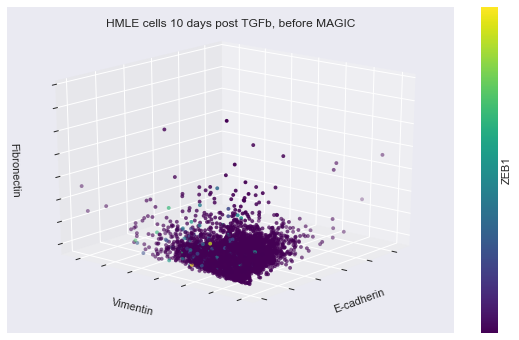

In [112]:
# plot data before MAGIC
# Here we plot three canonical EMT genes before imputation
x = df["CDH1"]
y = df["VIM"]
z = df["FN1"]
c = df["ZEB1"]
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
plt.setp(ax, xticklabels=[], yticklabels=[], zticklabels=[])
im = ax.scatter(x, y, z, s=15, linewidths=0, c=c, cmap=cm.viridis)
cbar = fig.colorbar(im, ax=ax)
cbar.set_ticks([])
cbar.set_label('ZEB1')
ax.set_xlabel("E-cadherin")
ax.set_ylabel("Vimentin")
ax.set_zlabel("Fibronectin")
ax.set_title("HMLE cells 10 days post TGFb, before MAGIC")
ax.view_init(20, 220)
plt.show()

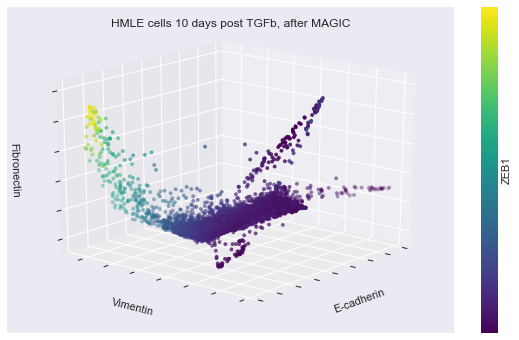

In [113]:
# plot data after MAGIC
# Here we plot three canonical EMT genes after imputation
x = df_new["CDH1"]
y = df_new["VIM"]
z = df_new["FN1"]
c = df_new["ZEB1"]
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
plt.setp(ax, xticklabels=[], yticklabels=[], zticklabels=[])
im = ax.scatter(x, y, z, s=15, linewidths=0, c=c, cmap=cm.viridis)
cbar = fig.colorbar(im, ax=ax)
cbar.set_ticks([])
cbar.set_label('ZEB1')
ax.set_xlabel("E-cadherin")
ax.set_ylabel("Vimentin")
ax.set_zlabel("Fibronectin")
ax.set_title("HMLE cells 10 days post TGFb, after MAGIC")
ax.view_init(20, 220)
plt.show()

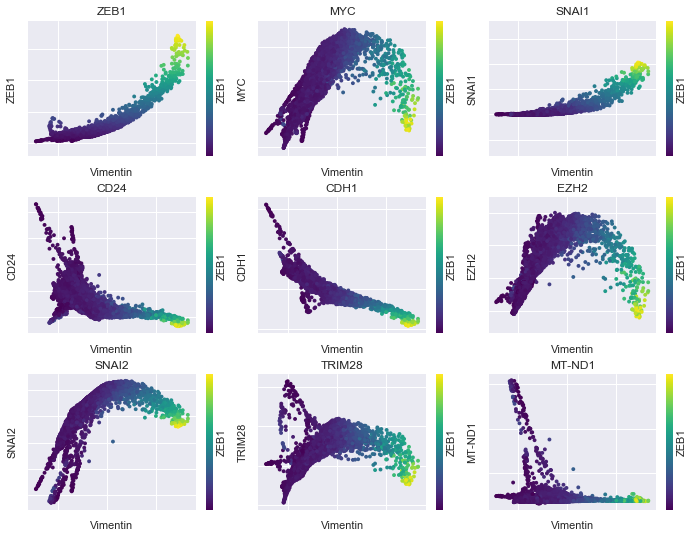

In [118]:
# MAGIC 2D
# Here we plot several genes
f, axes = plt.subplots(3,3)
f.set_size_inches(12,9)
f.subplots_adjust(hspace = .3, wspace=.1)
plt.setp(axes, xticklabels=[], yticklabels=[])
axs = axes.ravel()

genes = ['ZEB1','MYC','SNAI1','CD24','CDH1','EZH2','SNAI2','TRIM28','MT-ND1']

for i in range(len(genes)):
    curr_gene = genes[i]
    x = df_new["VIM"]
    c = df_new["ZEB1"]
    y = df_new[curr_gene]
    im = axs[i].scatter(x, y, s=15, linewidths=0, c=c, cmap=cm.viridis)
    axs[i].set_xlabel("Vimentin")
    axs[i].set_ylabel(curr_gene)
    axs[i].set_title(curr_gene)
    cbar = fig.colorbar(im, ax=axs[i])
    cbar.set_ticks([])
    cbar.set_label("ZEB1")
    
plt.show()

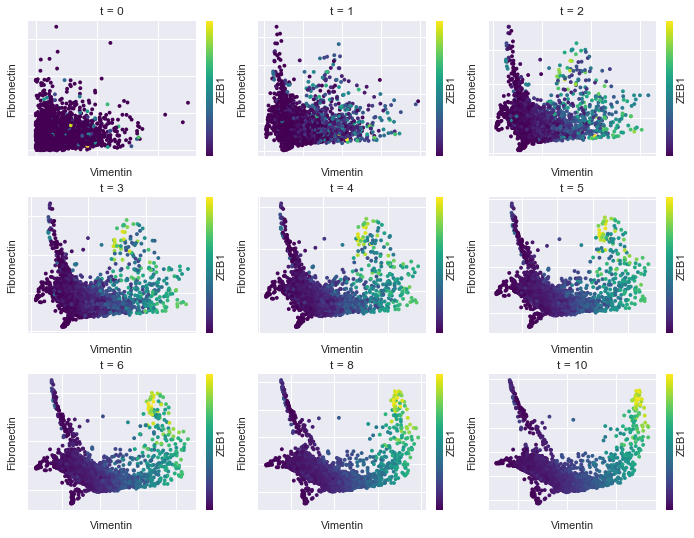

In [119]:
# MAGIC per t
# here we investigate the behavior of the parameter t, i.e. the diffusion time
f, axes = plt.subplots(3,3)
f.set_size_inches(12,9)
f.subplots_adjust(hspace = .3, wspace=.1)
plt.setp(axes, xticklabels=[], yticklabels=[])
axs = axes.ravel()

t_vec = (0,1,2,3,4,5,6,8,10)

for i in range(len(t_vec)):
    t_curr = t_vec[i]
    diff_op_t_curr = np.linalg.matrix_power(diff_op, t_curr) # diffuse t steps by powering the operator
    data_new_curr = np.array(np.dot(diff_op_t_curr, data)) # multiply diffused operator with data
    df_new_curr = pd.DataFrame(data=data_new_curr, columns=df.columns.tolist())
    x = df_new_curr["VIM"]
    y = df_new_curr["FN1"]
    c = df_new_curr["ZEB1"]
    im = axs[i].scatter(x, y, s=15, linewidths=0, c=c, cmap=cm.viridis)
    axs[i].set_xlabel("Vimentin")
    axs[i].set_ylabel("Fibronectin")
    axs[i].set_title('t = ' + str(t_curr))
    cbar = fig.colorbar(im, ax=axs[i])
    cbar.set_ticks([])
    cbar.set_label('ZEB1')
    
plt.show()